In [16]:
import dataclasses
from collections.abc import Iterator, Mapping
from types import MappingProxyType
from typing import Any, Literal, Optional

import jax
import jax.numpy as jnp
import sklearn
import sklearn.datasets

import optax

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from ott import datasets
from ott.geometry import costs, pointcloud

from ott.tools import sinkhorn_divergence

import jax
import jax.numpy as jnp
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import scipy
import numpy as np

from typing import Any, Optional

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib import colors

from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers import linear
from ott.tools import progot
import scipy

import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
sys.path.insert(0, '../src/')
import importlib
import FRLC
from FRLC import FRLC_opt
import HR_OT
importlib.reload(HR_OT)

import torch.multiprocessing as mp


In [17]:
global n_points;
n_points = 512

In [18]:
def plot_eval_samples(
    eval_data_source, eval_data_target, transported_samples=None
):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
        label="source",
    )
    axs[0].set_title("Source measure samples")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
        label="target",
    )
    axs[1].set_title("Target measure samples")

    if transported_samples is not None:
        axs[1].scatter(
            transported_samples[:, 0],
            transported_samples[:, 1],
            color="#F2545B",
            s=10,
            alpha=0.5,
            label="pushforward of source",
        )

    fig.legend(
        **{
            "ncol": (3 if transported_samples is not None else 2),
            "loc": "upper center",
            "bbox_to_anchor": (0.5, 0.1),
            "edgecolor": "k",
        }
    )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, ax

@dataclasses.dataclass
class MAFMoonSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        x = jax.random.normal(key, shape=[batch_size, 2])
        x = x.at[:, 0].add(x[:, 1] ** 2)
        x = x.at[:, 0].mul(0.5)
        x = x.at[:, 0].add(-5)
        return x


@dataclasses.dataclass
class RingSampler:
    size: int

    def __iter__(self):
        rng = jax.random.key(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)

    def _sample(self, key, batch_size):
        n_samples4 = n_samples3 = n_samples2 = batch_size // 4
        n_samples1 = batch_size - n_samples4 - n_samples3 - n_samples2

        linspace4 = jnp.linspace(0, 2 * jnp.pi, n_samples4, endpoint=False)
        linspace3 = jnp.linspace(0, 2 * jnp.pi, n_samples3, endpoint=False)
        linspace2 = jnp.linspace(0, 2 * jnp.pi, n_samples2, endpoint=False)
        linspace1 = jnp.linspace(0, 2 * jnp.pi, n_samples1, endpoint=False)

        circ4_x = jnp.cos(linspace4) * 1.2
        circ4_y = jnp.sin(linspace4) * 1.2
        circ3_x = jnp.cos(linspace4) * 0.9
        circ3_y = jnp.sin(linspace3) * 0.9
        circ2_x = jnp.cos(linspace2) * 0.55
        circ2_y = jnp.sin(linspace2) * 0.55
        circ1_x = jnp.cos(linspace1) * 0.25
        circ1_y = jnp.sin(linspace1) * 0.25

        X = (
            jnp.vstack(
                [
                    jnp.hstack([circ4_x, circ3_x, circ2_x, circ1_x]),
                    jnp.hstack([circ4_y, circ3_y, circ2_y, circ1_y]),
                ]
            ).T
            * 3.0
        )
        X = sklearn.utils.shuffle(X)

        # Add noise
        X = X + jax.random.normal(key, shape=X.shape) * 0.08

        return X.astype("float32")

@dataclasses.dataclass
class SklearnDistribution:
    name: Literal["moon", "s_curve"]
    theta_rotation: float = 0.0
    mean: Optional[jnp.ndarray] = None
    noise: float = 0.01
    scale: float = 1.0
    batch_size: int = 1024
    rng: Optional[jax.Array] = None

    def __iter__(self) -> Iterator[jnp.ndarray]:
        return self._create_sample_generators()

    def _create_sample_generators(self) -> Iterator[jnp.ndarray]:
        rng = jax.random.key(0) if self.rng is None else self.rng
        rotation = jnp.array(
            [
                [jnp.cos(self.theta_rotation), -jnp.sin(self.theta_rotation)],
                [jnp.sin(self.theta_rotation), jnp.cos(self.theta_rotation)],
            ]
        )
        while True:
            rng, _ = jax.random.split(rng)
            seed = jax.random.randint(rng, [], minval=0, maxval=1e5).item()
            if self.name == "moon":
                samples, _ = sklearn.datasets.make_moons(
                    n_samples=(self.batch_size, 0),
                    random_state=seed,
                    noise=self.noise,
                )
            elif self.name == "s_curve":
                x, _ = sklearn.datasets.make_s_curve(
                    n_samples=self.batch_size,
                    random_state=seed,
                    noise=self.noise,
                )
                samples = x[:, [2, 0]]
            else:
                raise NotImplementedError(
                    f"SklearnDistribution `{self.name}` not implemented."
                )

            samples = jnp.asarray(samples, dtype=jnp.float32)
            samples = jnp.squeeze(jnp.matmul(rotation[None, :], samples.T).T)
            mean = jnp.zeros(2) if self.mean is None else self.mean
            samples = mean + self.scale * samples
            yield samples


def create_samplers(
    source_kwargs: Mapping[str, Any] = MappingProxyType({}),
    target_kwargs: Mapping[str, Any] = MappingProxyType({}),
    train_batch_size: int = 512,
    valid_batch_size: int = 512,
    rng: Optional[jax.Array] = None,
):
    rng = jax.random.key(0) if rng is None else rng
    rng1, rng2, rng3, rng4 = jax.random.split(rng, 4)
    train_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng1, batch_size=train_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng2, batch_size=train_batch_size, **target_kwargs
            )
        ),
    )
    valid_dataset = datasets.Dataset(
        source_iter=iter(
            SklearnDistribution(
                rng=rng3, batch_size=valid_batch_size, **source_kwargs
            )
        ),
        target_iter=iter(
            SklearnDistribution(
                rng=rng4, batch_size=valid_batch_size, **target_kwargs
            )
        ),
    )
    dim_data = 2
    return train_dataset, valid_dataset, dim_data

def ret_pts(experiment, n_points = 512):
    if experiment == 'checkerboard':
    
        num_samples_visualize = n_points
        (
            train_dataloaders,
            valid_dataloaders,
            input_dim,
        ) = datasets.create_gaussian_mixture_samplers(
            name_source="square_five",
            name_target="square_four",
            valid_batch_size=num_samples_visualize,
            train_batch_size=2048,
        )
        
        eval_data_source = next(valid_dataloaders.source_iter)
        eval_data_target = next(valid_dataloaders.target_iter)
        
        eval_data_source = next(valid_dataloaders.source_iter)
        eval_data_target = next(valid_dataloaders.target_iter)
    
    elif experiment == 'maf_moon_ring':
        
        train_loader = datasets.Dataset(
        source_iter=iter(MAFMoonSampler(size=n_points)),
        target_iter=iter(RingSampler(size=n_points)),
        )
        valid_loader = train_loader
        
        eval_data_source = next(train_loader.source_iter)
        eval_data_target = next(train_loader.target_iter)
    
    elif experiment == 'halfmoon_Scurve':
    
        train_dataset, valid_dataset, dim_data = create_samplers(
        source_kwargs={
            "name": "moon",
            "theta_rotation": jnp.pi / 6,
            "mean": jnp.array([0.0, -0.5]),
            "noise": 0.05,
        },
        target_kwargs={
            "name": "s_curve",
            "scale": 0.6,
            "mean": jnp.array([0.5, -2.0]),
            "theta_rotation": -jnp.pi / 6,
            "noise": 0.05,
            },
            train_batch_size=n_points,
            valid_batch_size=n_points)
        eval_data_source = next(train_dataset.source_iter)
        eval_data_target = next(train_dataset.target_iter)

    return eval_data_source, eval_data_target

In [19]:
@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)
    
    _, out = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    
    return out.divergence


def run_progot(
    x: jnp.ndarray, y: jnp.ndarray, cost_fn: costs.TICost, **kwargs: Any
) -> progot.ProgOTOutput:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    estim = progot.ProgOT(**kwargs)
    out = estim(prob)
    return out

K = 4
cost_fn = costs.SqEuclidean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64


On device: cpu


In [28]:
def plot_proj(P):
    
    if isinstance(P, torch.Tensor):
        P = P.cpu().numpy()
    
    opt_target = np.diag(1 / np.sum(P, axis=1)) @ P @ Y
    for idx1 in range(P.shape[0]):
        x_values = X[idx1, 0], opt_target[idx1, 0]
        y_values = X[idx1, 1], opt_target[idx1, 1]
        plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)
    
    plt.scatter(X[:, 0], X[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
    plt.scatter(Y[:, 0], Y[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
    plt.scatter(opt_target[:, 0], opt_target[:, 1], c='gold', label='Optimal Map', alpha=0.7)
    
    plt.show()

32
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


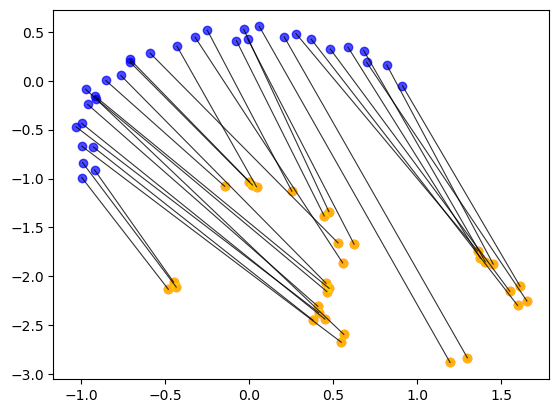

Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


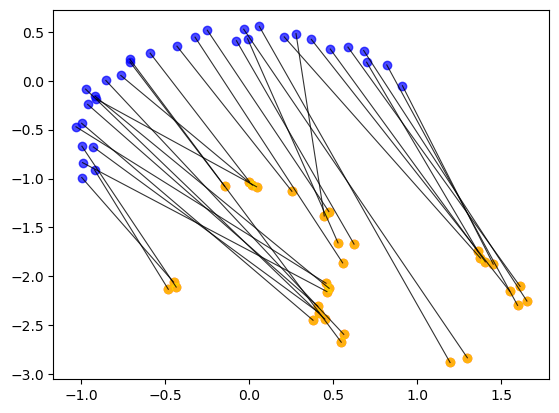

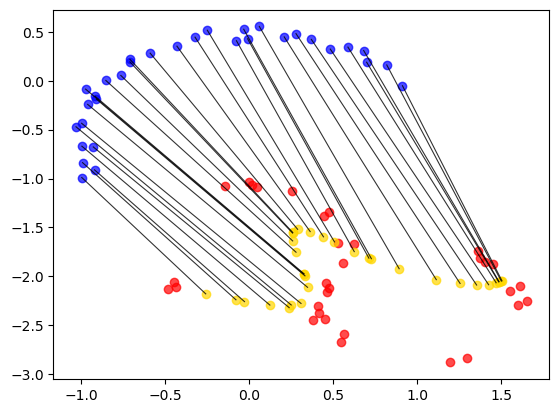

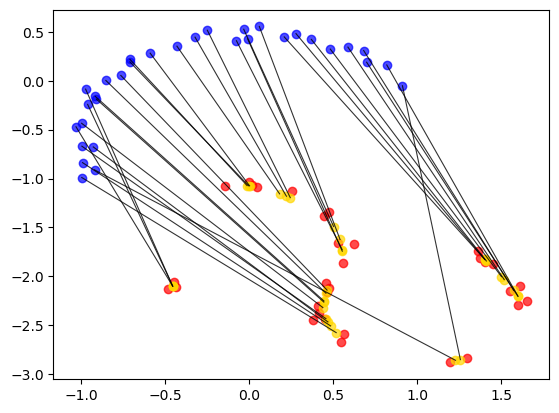

cost HROT: 2.2182275927834434, cost HROT-LR: 2.226067867531814, cost Sink: 2.2296247482299805, cost progOT: 2.236151933670044
64
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25


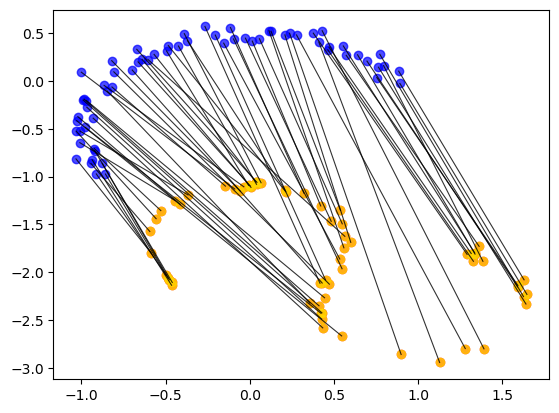

Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


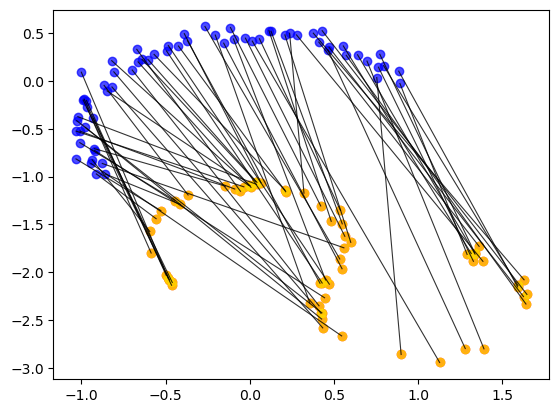

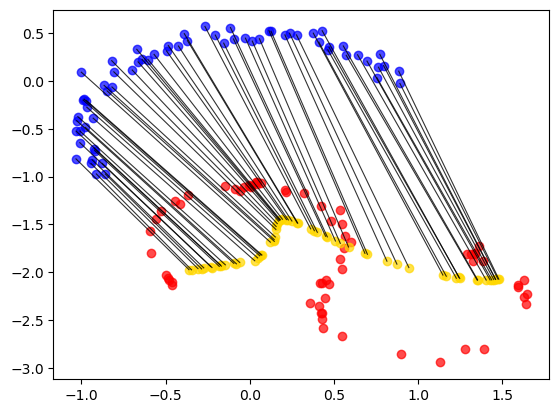

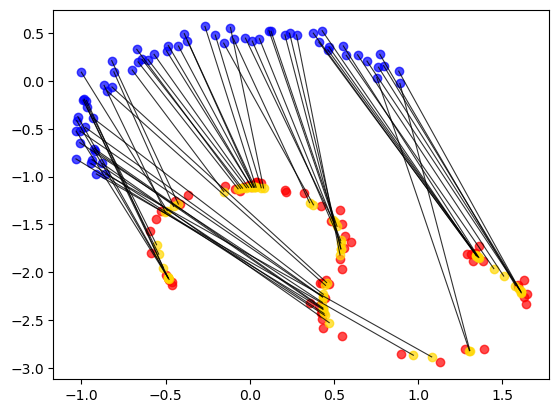

cost HROT: 2.015882626710704, cost HROT-LR: 2.0388121673940294, cost Sink: 2.0271034240722656, cost progOT: 2.036025047302246
128
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


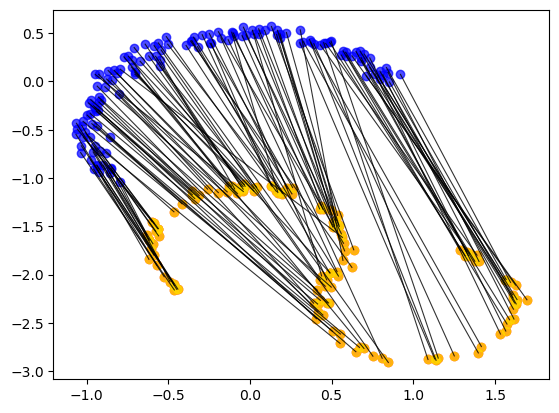

Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25


In [ ]:
importlib.reload(HR_OT)
import objective_grad
import util
importlib.reload(FRLC)
importlib.reload(objective_grad)
importlib.reload(util)

sample_sizes = [int(2**i) for i in range(5, 18, 1)]

experiment = 'halfmoon_Scurve' #'checkerboard'#'halfmoon_Scurve' #'maf_moon_ring'
plot_pts =  False

cost_list = []

# Squared Euclidean cost p=2 or Euclidean if p=1
p = 1
K = 8

for n in sample_sizes:
    print(n)
    X, Y = ret_pts(experiment, n_points = n)
    
    # Define pairwise Dist Mat
    _X, _Y = torch.tensor(np.array(X)).type(torch.DoubleTensor).to(device), \
                        torch.tensor(np.array(Y)).type(torch.DoubleTensor).to(device)
    
    C = torch.cdist( _X, _Y ) ** p
    #C = C / C.max()
    
    rank_schedule = [ K, int( n / K ) ] # Total of (1+K) runs of low-rank OT req'd
    
    # Full-rank cost matrix
    hrot = HR_OT.HierarchicalRefinementOT(C, \
                                  rank_schedule, \
                                  base_rank=1)
    P = hrot.run(return_as_coupling=True)
    cost_hrot = hrot.compute_OT_cost()
    plot_proj(P)

    # Low-rank cost matrix
    hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(_X, _Y, \
                                  rank_schedule, base_rank=1)
    P = hrot_lr.run(return_as_coupling=True)
    plot_proj(P)
    cost_hrot_lr = hrot_lr.compute_OT_cost()
    
    #Sinkhorn Sol'n
    geom = Geometry( C.cpu().numpy() )
    ot_problem = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot_solution = solver(ot_problem)
    P_sinkhorn = ot_solution.matrix
    plot_proj(np.array(P_sinkhorn))
    cost_sink = ( C.cpu().numpy() * P_sinkhorn ).sum()

    # ProgOT Sol'n
    x_train, y_train = X, Y
    alphas = progot.get_alpha_schedule("exp", num_steps=K)
    out = run_progot(X, Y, \
                     cost_fn, alphas=alphas, \
                     epsilons=None)
    P_progOT_default = out.get_output(-1).matrix
    plot_proj(np.array(P_progOT_default))
    cost_progOT = ( C.cpu().numpy() * P_progOT_default ).sum()

    print(f'cost HROT: { cost_hrot.item() }, cost HROT-LR: { cost_hrot_lr.item() \
                                                }, cost Sink: { cost_sink }, cost progOT: { cost_progOT }')
    
    if plot_pts:
        fig, ax = plot_eval_samples(eval_data_source, eval_data_target)
        display(fig)
        plt.close(fig)





# Evaluation against Sinkhorn

In [70]:
import statistics
importlib.reload(HR_OT)


rank_schedule = [ 4 , 128 ]

import time

s = time.time()
P_2 = HR_OT.hierarchical_refinement(C.to('cpu'), \
                                  torch.tensor(rank_schedule), FRLC_opt, \
                                  base_rank=1, \
                                 return_as_coupling=True)
e = time.time()
print(f'parallel {e - s}')
cost_hr_ot = torch.sum( C.to(device) * P_2.to(device) )

'''
s = time.time()
P = HR_OT.hierarchical_refinement(C, \
                                  torch.tensor(rank_schedule), FRLC_opt, \
                                  device=device, base_rank=1,
                                 return_as_coupling=True)
e = time.time()
print(f'sequential {e - s}')
cost_hr_ot = torch.sum( C.to(device) * P.to(device) )
'''

'''
Sinkhorn Sol'n
'''

geom = Geometry( C.cpu().numpy() )
ot_problem = linear_problem.LinearProblem(geom)
solver = sinkhorn.Sinkhorn()
ot_solution = solver(ot_problem)
P_sinkhorn = ot_solution.matrix

'''
ProgOT Sol'n
'''

x_train, y_train = eval_data_source, eval_data_target 

alphas = progot.get_alpha_schedule("exp", num_steps=K)

out = run_progot(eval_data_source, eval_data_target, \
                 cost_fn, alphas=alphas, \
                 epsilons=None)

xs, ys = out.transport(eval_data_source, return_intermediate=False)

P_progOT_default = out.get_output(-1).matrix

cost_Sinkhorn = np.sum( C.cpu().numpy() * P_sinkhorn )
cost_prog_default = np.sum( C.cpu().numpy() * P_progOT_default )

'''
end_epsilon_scales = jnp.logspace(-10, -9, 4, base=2)
geom = pointcloud.PointCloud(
    x_train, y_train, cost_fn=cost_fn
)

tuned_epsilons = progot.get_epsilon_schedule(
    geom,
    alphas=alphas,
    epsilon_scales=end_epsilon_scales,
    start_epsilon_scale=0.5,
    y_eval=y_train,
)

out_tuned = run_progot(
    x_train, y_train, cost_fn, alphas=alphas, epsilons=tuned_epsilons
)

P_progOT_tuned = out_tuned.get_output(-1).matrix
cost_prog_tuned = (P_progOT_tuned * C).sum()
'''

'''
compute deterministic costs
'''

if p == 2:
    print(f'Comparing costs for p={p}, Sinkhorn: {cost_Sinkhorn} Default ProgOT { \
                                    cost_prog_default}, Hierarchical-refinement: {cost_hr_ot}')
elif p == 1:
    print(f'Comparing costs for p={p}, Sinkhorn: {cost_Sinkhorn}, Hierarchical-refinement: {cost_hr_ot}')


On device: cpu
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
parallel 20.442185401916504
Comparing costs for p=2, Sinkhorn: 0.33798637986183167 Default ProgOT 0.33431822061538696, Hierarchical-refinement: 0.33443608502764055


In [71]:
print(scipy.stats.entropy(P_sinkhorn.flatten()))
print(scipy.stats.entropy(P_progOT_default.flatten()))
print(scipy.stats.entropy(P_2.flatten()))

print( np.sum( P_sinkhorn > 1e-8 ) )
print( np.sum( P_progOT_default > 1e-8 ) )
print( np.sum( P_2.numpy() > 1e-8 ) )

11.386314
10.729503
6.238326
182546
95155
512


<Figure size 1000x800 with 0 Axes>

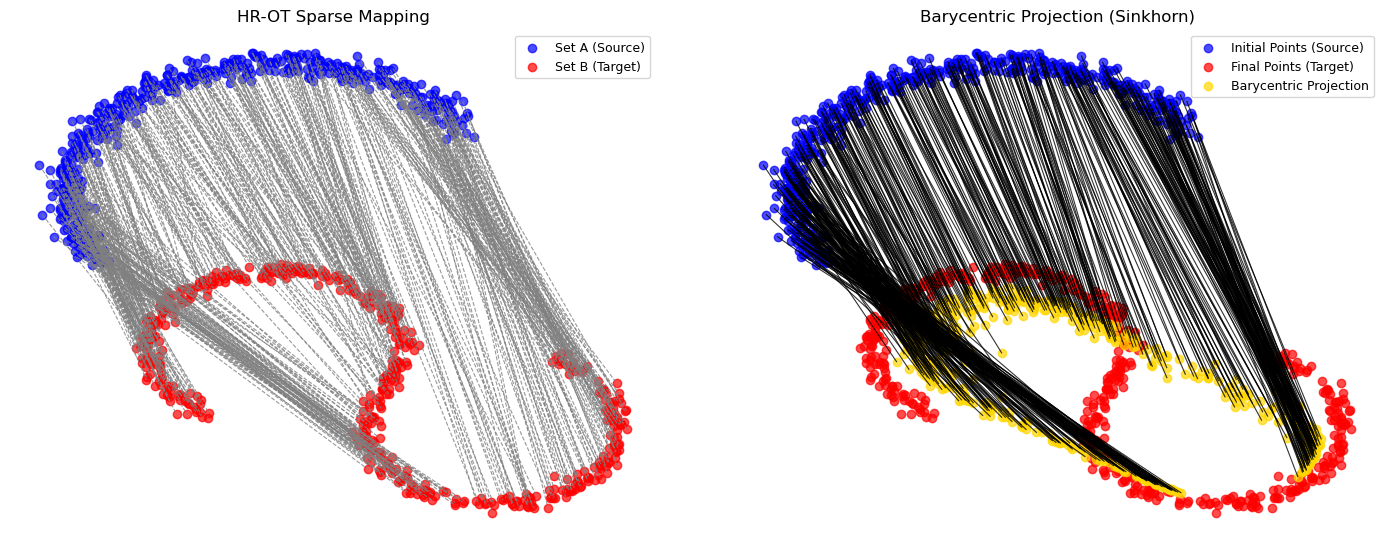

In [72]:
plt.figure(figsize=(10, 8))

pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn @ eval_data_target

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Mapping between Set A and Set B
for idx1 in range(P_2.shape[0]):
    idx2 = int(np.argmax(P_2[idx1, :]))
    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]
    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]
    axes[0].plot(x_values, y_values, c='gray', linestyle='--', linewidth=0.8, alpha=0.8)

axes[0].scatter(eval_data_source[:, 0], eval_data_source[:, 1], c='b', label='Set A (Source)', alpha=0.7)
axes[0].scatter(eval_data_target[:, 0], eval_data_target[:, 1], c='r', label='Set B (Target)', alpha=0.7)

axes[0].set_title("HR-OT Sparse Mapping", fontsize=12)
axes[0].set_xlabel("X-coordinate", fontsize=10)
axes[0].set_ylabel("Y-coordinate", fontsize=10)
axes[0].legend(fontsize=9, loc='upper right')
axes[0].grid(alpha=0.3)
axes[0].axis('off')

# Second subplot: Mapping with Barycentric Projection
for idx1 in range(P_sinkhorn.shape[0]):
    x_values = eval_data_source[idx1, 0], pred_target_sinkhorn[idx1, 0]
    y_values = eval_data_source[idx1, 1], pred_target_sinkhorn[idx1, 1]
    axes[1].plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)

axes[1].scatter(eval_data_source[:, 0], eval_data_source[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
axes[1].scatter(eval_data_target[:, 0], eval_data_target[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
axes[1].scatter(pred_target_sinkhorn[:, 0], pred_target_sinkhorn[:, 1], c='gold', label='Barycentric Projection', alpha=0.7)

axes[1].set_title("Barycentric Projection (Sinkhorn)", fontsize=12)
axes[1].set_xlabel("X-coordinate", fontsize=10)
axes[1].set_ylabel("Y-coordinate", fontsize=10)
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()
axes[1].axis('off')

# Save the figure as a high-quality image
plt.savefig(experiment + ".png", dpi=300)
plt.show()

opt cost: 0.33169667080920073


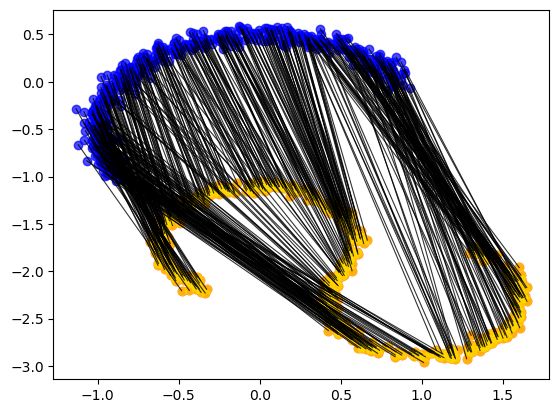

In [73]:
from validation import solve_ot_lp

gamma_LP, opt_cost = solve_ot_lp( np.ones(C.shape[0])/C.shape[0] , np.ones(C.shape[1])/C.shape[1], C.cpu().detach().numpy() )
print(f'opt cost: { opt_cost }')
opt_target = np.diag(1 / np.sum(gamma_LP, axis=1)) @ gamma_LP @ eval_data_target

for idx1 in range(gamma_LP.shape[0]):
    x_values = eval_data_source[idx1, 0], opt_target[idx1, 0]
    y_values = eval_data_source[idx1, 1], opt_target[idx1, 1]
    plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)

plt.scatter(eval_data_source[:, 0], eval_data_source[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
plt.scatter(eval_data_target[:, 0], eval_data_target[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
plt.scatter(opt_target[:, 0], opt_target[:, 1], c='gold', label='Optimal Map', alpha=0.7)

plt.show()

In [74]:
'''
pred_target = np.diag(1 / np.sum(P_2.cpu().numpy(), axis=1)) @ P_2.cpu().numpy() @ eval_data_target

for idx1 in range(P_2.shape[0]):
    x_values = eval_data_source[idx1, 0], pred_target[idx1, 0]
    y_values = eval_data_source[idx1, 1], pred_target[idx1, 1]
    plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)

plt.scatter(eval_data_source[:, 0], eval_data_source[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)
plt.scatter(eval_data_target[:, 0], eval_data_target[:, 1], c='r', label='Final Points (Target)', alpha=0.7)
plt.scatter(pred_target[:, 0], pred_target[:, 1], c='gold', label='Optimal Map', alpha=0.7)

plt.show()'''

"\npred_target = np.diag(1 / np.sum(P_2.cpu().numpy(), axis=1)) @ P_2.cpu().numpy() @ eval_data_target\n\nfor idx1 in range(P_2.shape[0]):\n    x_values = eval_data_source[idx1, 0], pred_target[idx1, 0]\n    y_values = eval_data_source[idx1, 1], pred_target[idx1, 1]\n    plt.plot(x_values, y_values, c='black', linewidth=0.8, alpha=0.8)\n\nplt.scatter(eval_data_source[:, 0], eval_data_source[:, 1], c='b', label='Initial Points (Source)', alpha=0.7)\nplt.scatter(eval_data_target[:, 0], eval_data_target[:, 1], c='r', label='Final Points (Target)', alpha=0.7)\nplt.scatter(pred_target[:, 0], pred_target[:, 1], c='gold', label='Optimal Map', alpha=0.7)\n\nplt.show()"

In [75]:
pred_target = np.diag(1 / np.sum(P_2.cpu().numpy(), axis=1)) @ P_2.cpu().numpy() @ eval_data_target

print( (np.linalg.norm(pred_target - opt_target, axis=1)).mean() )
print( (np.linalg.norm(pred_target_sinkhorn - opt_target, axis=1)).mean() )


0.2879237
0.25384706


In [32]:
'''
import torch.nn as nn
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

M1 = pred_target_sinkhorn - eval_data_source
M2 = pred_target - eval_data_source
M = opt_target - eval_data_source

cos_sink = cos( torch.tensor(np.array(M1)).view(-1) , torch.tensor(np.array(M)).view(-1) )
cos_hrot = cos( torch.tensor(np.array(M2)).view(-1) , torch.tensor(np.array(M)).view(-1) )

print(f'cosine similarity (Sinkhorn): {cos_sink}, (HROT): {cos_hrot}')
'''

cosine similarity (Sinkhorn): 0.99132239818573, (HROT): 0.9877609014511108


ranks: 128, 4
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
I

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

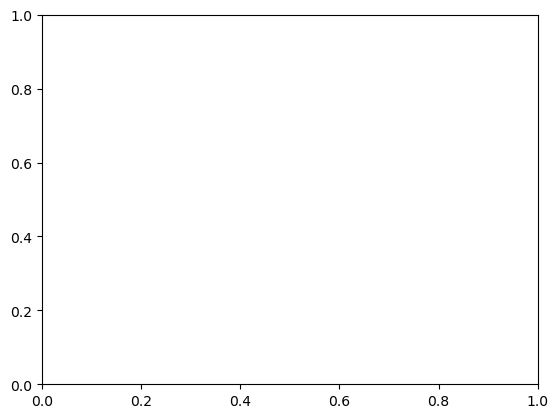

In [51]:
'''
importlib.reload(HR_OT)

rank_schedules = [
         [128, 4],
        [64, 8],
        [32, 16],
        [16, 32],
        [8, 64],
        [4,128]]

cost_lst = []

for rank_schedule in rank_schedules:
    print(f'ranks: {rank_schedule[0]}, {rank_schedule[1]}')
    P_2 = HR_OT.hierarchical_refinement(C.to('cpu'), \
                                      torch.tensor(rank_schedule), FRLC_opt, \
                                      base_rank=1, \
                                     return_as_coupling=True)
    
    cost_hr_ot = torch.sum( C.to(device) * P_2.to(device) )
    print(cost_hr_ot)
    cost_lst.append(cost_hr_ot)
'''

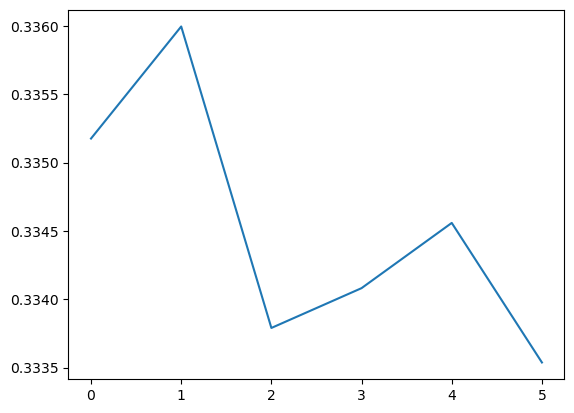

In [52]:
plt.plot(range(len(cost_lst)), torch.tensor(cost_lst).numpy() )
plt.show()

In [44]:
'''
for idx1 in range(P_2.shape[0]):
    idx2 = int(np.argmax(P_2[idx1, :])) # only 1 index
    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]
    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()

pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target

pred_target_sinkhorn = pred_target_sinkhorn
X, Y = eval_data_source, eval_data_target

for idx1 in range(P_sinkhorn.shape[0]):
    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]
    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(X[:,0], X[:,1], c='b', label=r'Initial points', alpha=0.5)
plt.scatter(Y[:,0], Y[:,1], c='r', label=r'Final points', alpha=0.5)
plt.scatter(pred_target_sinkhorn[:,0], pred_target_sinkhorn[:,1], c='y', label=r'Barycentric projection', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()'''

"\nfor idx1 in range(P_2.shape[0]):\n    idx2 = int(np.argmax(P_2[idx1, :])) # only 1 index\n    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]\n    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)\nplt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)\n\n#plt.savefig('example_sparse.png')\nplt.show()\n\npred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target\n\npred_target_sinkhorn = pred_target_sinkhorn\nX, Y = eval_data_source, eval_data_target\n\nfor idx1 in range(P_sinkhorn.shape[0]):\n    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]\n    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(X[:,0], X[:,1], c='b', label=r'Initial points', alpha=0.5)\nplt.scatter(Y[:,0], 

In [1]:
'''
# Barycentric projection on Target (Sinkhorn)
pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn @ eval_data_target

print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target_sinkhorn, eval_data_target):.2f}"
)

# Barycentric projection on Source (Sinkhorn)
pred_source = np.diag(1 / np.sum(P_sinkhorn, axis=1)) @ P_sinkhorn.T @ eval_data_source

print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")
'''

'''
for idx1 in range(P.shape[0]):
    idx2 = int(np.argmax(P[idx1, :])) # only 1 index
    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]
    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()

pred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target

for idx1 in range(P_sinkhorn.shape[0]):
    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]
    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]
    plt.plot(x_values, y_values, c='black')

plt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Initial points', alpha=0.5)
plt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Final points', alpha=0.5)
plt.scatter(pred_target_sinkhorn[:,0], pred_target_sinkhorn[:,1], c='y', label=r'Barycentric projection', alpha=0.5)

#plt.savefig('example_sparse.png')
plt.show()
'''

"\nfor idx1 in range(P.shape[0]):\n    idx2 = int(np.argmax(P[idx1, :])) # only 1 index\n    x_values = eval_data_source[idx1, 0], eval_data_target[idx2, 0]\n    y_values = eval_data_source[idx1, 1], eval_data_target[idx2, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Set A', alpha=0.5)\nplt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Set B', alpha=0.5)\n\n#plt.savefig('example_sparse.png')\nplt.show()\n\npred_target_sinkhorn = np.diag(1 / np.sum(P_sinkhorn, axis=0)) @ P_sinkhorn @ eval_data_target\n\nfor idx1 in range(P_sinkhorn.shape[0]):\n    x_values = X[idx1, 0], pred_target_sinkhorn[idx1, 0]\n    y_values = X[idx1, 1], pred_target_sinkhorn[idx1, 1]\n    plt.plot(x_values, y_values, c='black')\n\nplt.scatter(eval_data_source[:,0], eval_data_source[:,1], c='b', label=r'Initial points', alpha=0.5)\nplt.scatter(eval_data_target[:,0], eval_data_target[:,1], c='r', label=r'Final point